In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr

In [2]:
os.makedirs('../plots', exist_ok=True)

In [3]:
pl.style.use('../defaults.mplstyle')

In [4]:
noch4r = xr.open_dataset('../results/noCH4R.nc')

In [5]:
ch4r = xr.open_dataset('../results/CH4R.nc')

In [6]:
noch4r_lifetime = xr.open_dataset('../results/noCH4R_lifetime.nc')

In [7]:
noch4r.temperature

<xarray.DataArray 'temperature' (timebound: 551, scenario: 3, config: 1001,
                                 layer: 3)>
[4963959 values with dtype=float64]
Coordinates:
  * config     (config) int32 394 1850 1923 2317 ... 1493662 1495531 1495865
  * timebound  (timebound) float64 1.75e+03 1.751e+03 ... 2.299e+03 2.3e+03
  * scenario   (scenario) object 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lowB...
  * layer      (layer) int32 0 1 2

In [8]:
ch4r.temperature

<xarray.DataArray 'temperature' (timebound: 551, scenario: 3, config: 1001)>
[1654653 values with dtype=float64]
Coordinates:
  * config     (config) int32 394 1850 1923 2317 ... 1493662 1495531 1495865
  * timebound  (timebound) int32 1750 1751 1752 1753 ... 2297 2298 2299 2300
  * scenario   (scenario) object 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lowB...

In [9]:
ecs_tcr = pd.read_csv('../results/ecs_tcr.csv', index_col=0)

In [10]:
temp_norm_20032022 = np.ones(21)
temp_norm_20032022[0] = 0.5
temp_norm_20032022[-1] = 0.5

In [11]:
colors = {
    'ssp119': '#00a9cf',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': '#B8BDAA',
    'ssp534-over': '#92397a'
}

In [12]:
scenarios = ['ssp119', 'COFFEE1.1 EN_NPi2020_400f_lowBECCS', 'ssp534-over']
labels = {
    'ssp119': 'SSP1-1.9',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': 'IMP-Neg (C2)',
    'ssp534-over': 'SSP5-3.4-OS'
}

In [13]:
def powerfit(x, a, b, c):
    return a + b * x**c

# def powerfit(x, b):
#     return 1.5 + b * x**0.5

In [14]:
quantiles = [.05, .25, .50, .75, .95]
mod = {}
res_all = {}
x_p = {}
df_p = {}
p = {}
cov = {}
exceeds = {}

for iscen, scenario in enumerate(scenarios):
    over1p5 = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )
    ) >= 1.5
    x = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5]/1000
    )
    y = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5]
    )
    exceeds[scenario] = (
        np.max(
            ch4r.temperature.loc[
                dict(scenario=scenario)
            ] - np.average(
                ch4r.temperature.loc[
                    dict(scenario=scenario, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data > 1.5
    )
    xe = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5 & ~exceeds[scenario]]/1000
    )
    ye = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5 & ~exceeds[scenario]]
    )
    
    d = {'peak': ye, 'ch4': xe}
    #d = {'peak': ye-1.5, 'ch4': xe}
    df = pd.DataFrame(data=d)
    
    # scipy curve_fit
    p[scenario], cov[scenario] = curve_fit(powerfit, xe, ye)
    
    # use the best estimate of the exponent from this to feed into the quantile regression
    
    # statsmodels fit
    mod[scenario] = smf.quantreg(f'peak ~  I(ch4 ** {p[scenario][2]})', df)
    #mod[scenario] = smf.quantreg(f'peak ~ I(ch4 ** 0.5) - 1', df)
    
    # get all result instances in a list
    res_all[scenario] = [mod[scenario].fit(q=q) for q in quantiles]
    x_p[scenario] = np.linspace(0, x.max(), 100)
    df_p[scenario] = pd.DataFrame({'ch4': x_p})

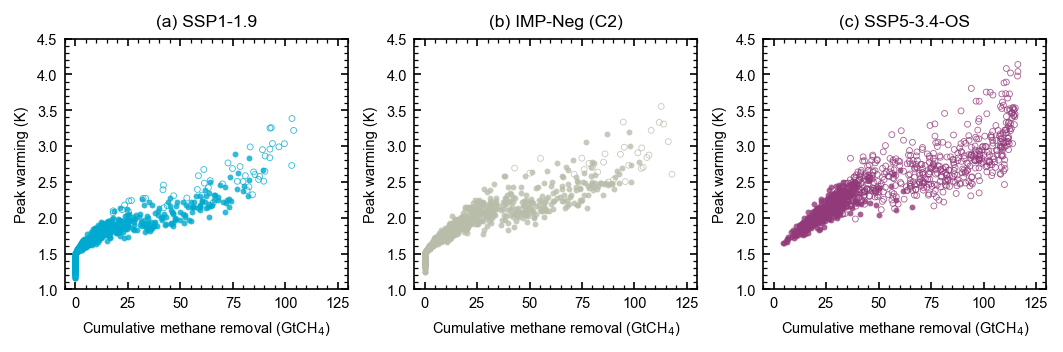

In [15]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
#     for qm, res in zip(quantiles, res_all[scenario]):
#         q[qm] = res.predict({'peak': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
#     ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
#     ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (K)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 4.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT.png')
pl.savefig('../plots/cumCH4_peakT.pdf')

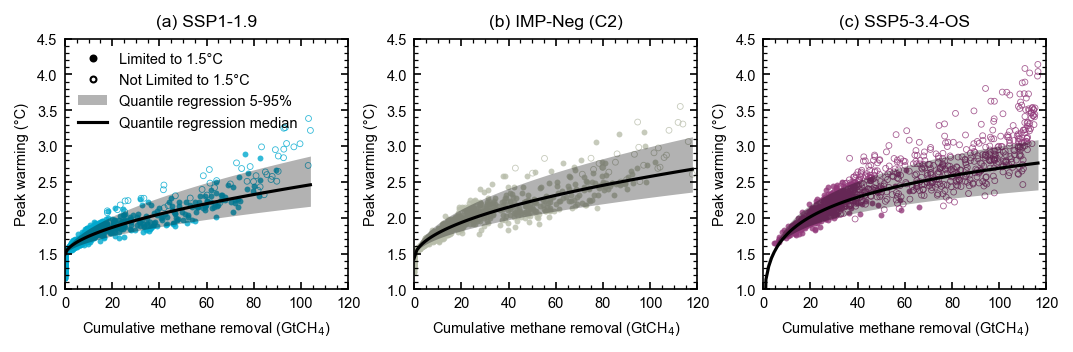

In [16]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_all[scenario]):
        q[qm] = res.predict({'ch4': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
    #ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    #ax[iscen].plot(x_p[scenario], q[.5], color='k')
    ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (°C)')
    ax[iscen].set_xlim(0, 120)
    ax[iscen].set_ylim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Not Limited to 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Quantile regression median'),
]
ax[0].legend(handles=legend_elements, loc='upper left', frameon=False)

fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_quant.png')
pl.savefig('../plots/cumCH4_peakT_quant.pdf')

In [17]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_all[scenario][qidx].params)
        print()

ssp119 0.05
Intercept                       1.484706
I(ch4 ** 0.5758684459828252)    0.046567
dtype: float64

ssp119 0.5
Intercept                       1.489011
I(ch4 ** 0.5758684459828252)    0.066969
dtype: float64

ssp119 0.95
Intercept                       1.488733
I(ch4 ** 0.5758684459828252)    0.094676
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept                      1.452782
I(ch4 ** 0.512942902441891)    0.078445
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept                      1.432163
I(ch4 ** 0.512942902441891)    0.107811
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept                      1.437359
I(ch4 ** 0.512942902441891)    0.146603
dtype: float64

ssp534-over 0.05
Intercept                        0.137998
I(ch4 ** 0.14129516573981374)    1.149430
dtype: float64

ssp534-over 0.5
Intercept                       -0.641020
I(ch4 ** 0.14129516573981374)    1.738318
dtype: float64

ssp534-over 0.95
Intercept     

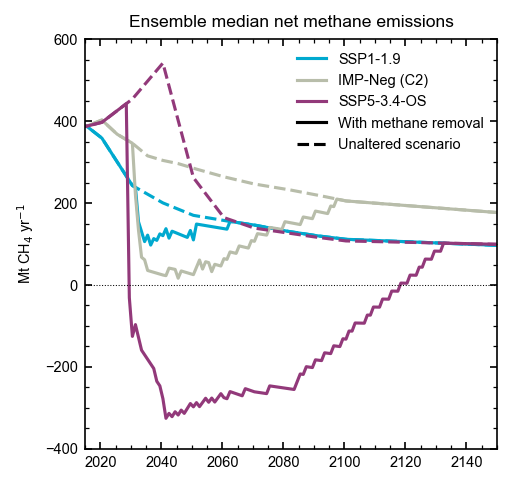

In [18]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
    
hands, labs = ax.get_legend_handles_labels()

hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')

ax.set_xlim(2015, 2150)
ax.set_ylim(-400, 600)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median net methane emissions');
pl.savefig('../plots/netCH4emissions.png')
pl.savefig('../plots/netCH4emissions.pdf')

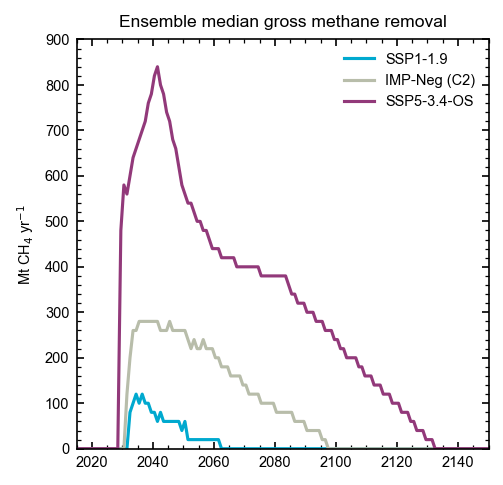

In [19]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax.set_xlim(2015, 2150)
ax.set_ylim(0, 900)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(frameon=False)
ax.set_title('Ensemble median gross methane removal');
pl.savefig('../plots/grossCH4removal.png')
pl.savefig('../plots/grossCH4removal.pdf')

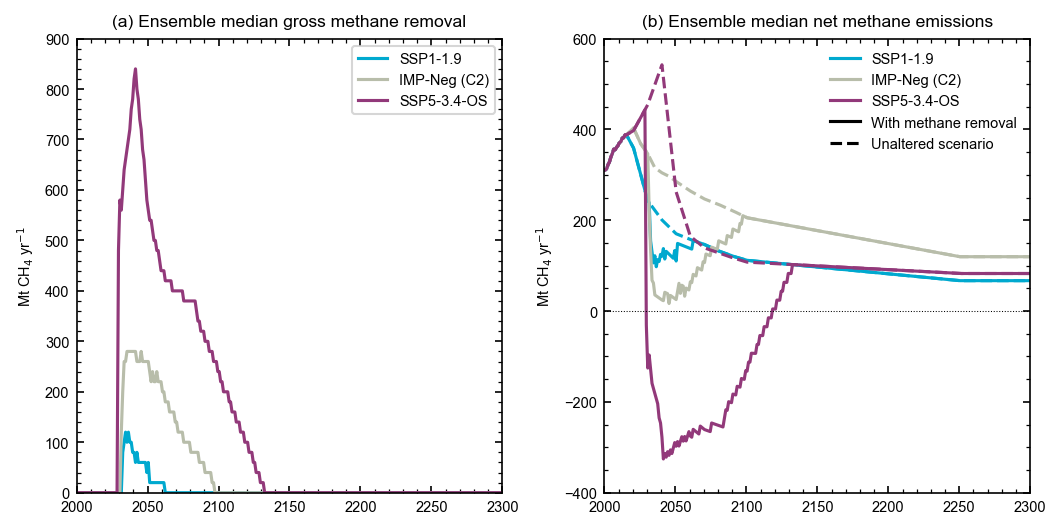

In [20]:
fig, ax = pl.subplots(1, 2, figsize=(18/2.54, 9/2.54))
for scenario in scenarios:
    ax[1].plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax[1].plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-400, 600)
ax[1].axhline(0, lw=0.5, ls=':', color='k')
ax[1].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[1].set_title('(b) Ensemble median net methane emissions');

hands, labs = ax[1].get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[1].legend(hands, labs, frameon=False)

for scenario in scenarios:
    ax[0].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0, 900)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[0].legend()
ax[0].set_title('(a) Ensemble median gross methane removal');
fig.tight_layout()

pl.savefig('../plots/netCH4emissions_grossCH4removal.png')
pl.savefig('../plots/netCH4emissions_grossCH4removal.pdf')

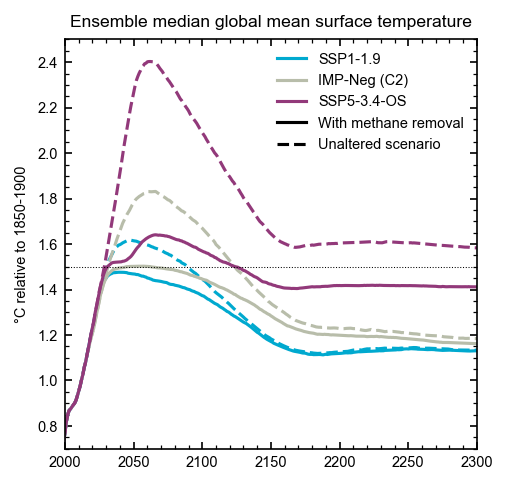

In [21]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.temperature.loc[dict(scenario=scenario, layer=0)], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.temperature.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0.7, 2.5)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('°C relative to 1850-1900')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median global mean surface temperature');
pl.savefig('../plots/temperature.png')
pl.savefig('../plots/temperature.pdf')

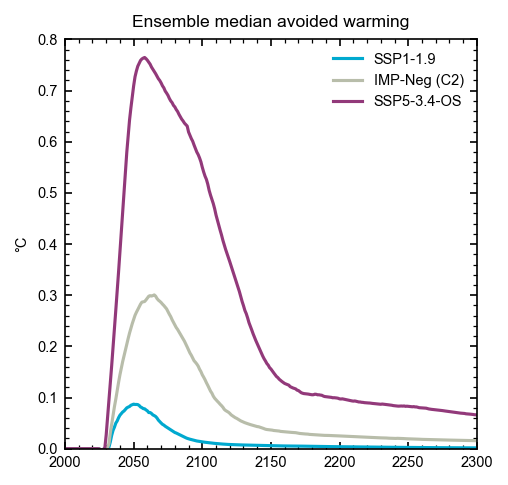

In [22]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(
            noch4r.temperature.loc[dict(scenario=scenario, layer=0)] - ch4r.temperature.loc[dict(scenario=scenario)],
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax.set_xlim(2000, 2300)
ax.set_ylim(0, 0.8)
ax.set_ylabel('°C')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(frameon=False)
ax.set_title('Ensemble median avoided warming');
pl.savefig('../plots/avoidedwarming.png')
pl.savefig('../plots/avoidedwarming.pdf')

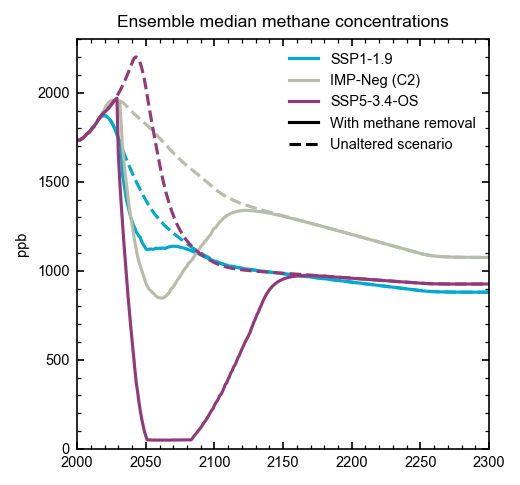

In [23]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.concentration.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.concentration.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0, 2300)
ax.set_ylabel('ppb')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane concentrations');
pl.savefig('../plots/CH4concentrations.png')
pl.savefig('../plots/CH4concentrations.pdf')

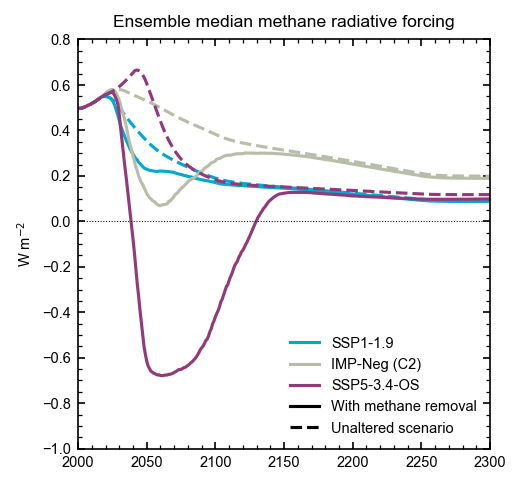

In [24]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_ch4.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_xlim(2000, 2300)
ax.set_ylim(-1, 0.8)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('W m$^{-2}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane radiative forcing');
pl.savefig('../plots/CH4forcing.png')
pl.savefig('../plots/CH4forcing.pdf')

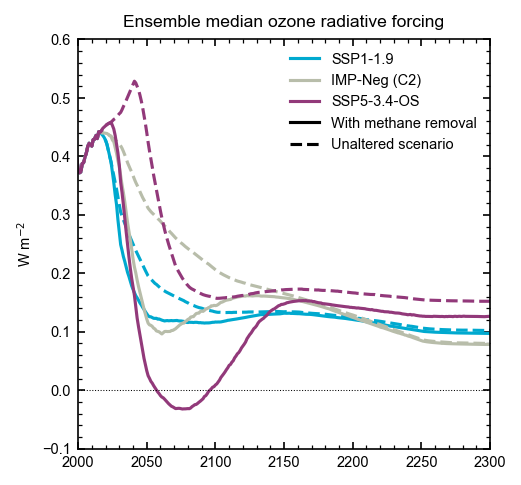

In [25]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='Ozone')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_o3.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(-0.1, 0.6)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median ozone radiative forcing');
pl.savefig('../plots/O3forcing.png')
pl.savefig('../plots/O3forcing.pdf')

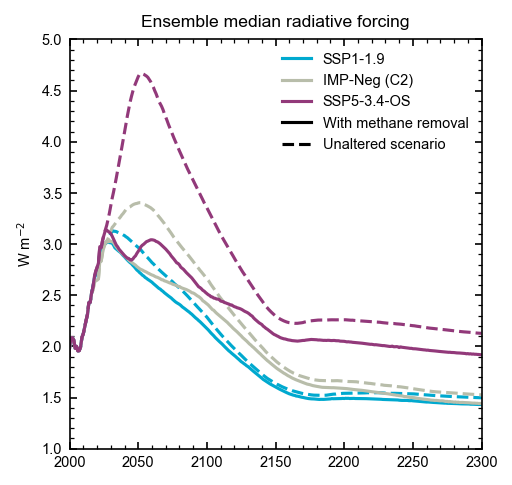

In [26]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        ls = '--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(1, 5)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median radiative forcing');
pl.savefig('../plots/totalforcing.png')
pl.savefig('../plots/totalforcing.pdf')

In [27]:
noch4r_lifetime.loc[dict(scenario=scenario)]

<xarray.Dataset>
Dimensions:                        (config: 1001, timebounds: 551)
Coordinates:
  * config                         (config) int32 394 1850 ... 1495531 1495865
  * timebounds                     (timebounds) float64 1.75e+03 ... 2.3e+03
    scenario                       <U11 'ssp534-over'
    specie                         object ...
Data variables:
    __xarray_dataarray_variable__  (timebounds, config) float64 ...

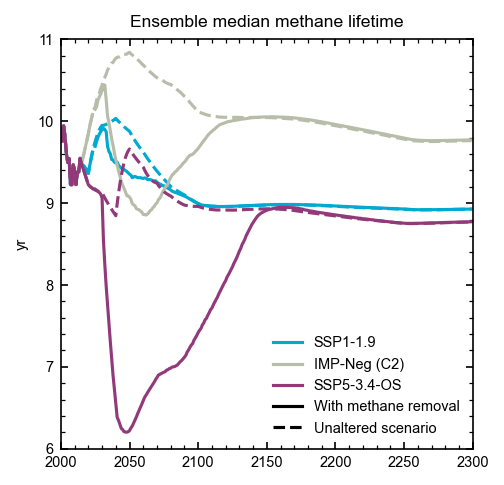

In [28]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r_lifetime.loc[dict(scenario=scenario)].__xarray_dataarray_variable__, axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.lifetime.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(6, 11)
ax.set_ylabel('yr')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane lifetime');
pl.savefig('../plots/CH4lifetime.png')
pl.savefig('../plots/CH4lifetime.pdf')

In [29]:
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')].shape

(550, 1001)

In [30]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

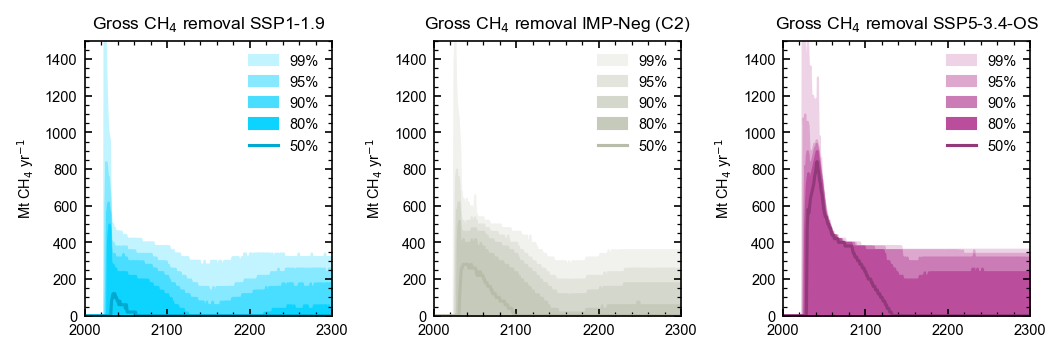

In [31]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):

    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            99,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.2),
        label='99%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            95,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.4),
        label='95%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            90,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.6),
        label='90%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            80,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.8),
        label='80%',
    );
    
    ax[iscen].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), 
        color=colors[scenario],
        label='50%',
    );
    ax[iscen].set_xlim(2000, 2300)
    ax[iscen].set_ylim(0,1500)
    #ax.set_ylim(0, 900)
    ax[iscen].set_ylabel('Mt CH$_4$ yr$^{-1}$')
    ax[iscen].legend(frameon=False)
    ax[iscen].set_title(f'Gross CH$_4$ removal {labels[scenario]}');
fig.tight_layout()
pl.savefig('../plots/grossCH4removalpercentiles.png')
pl.savefig('../plots/grossCH4removalpercentiles.pdf')

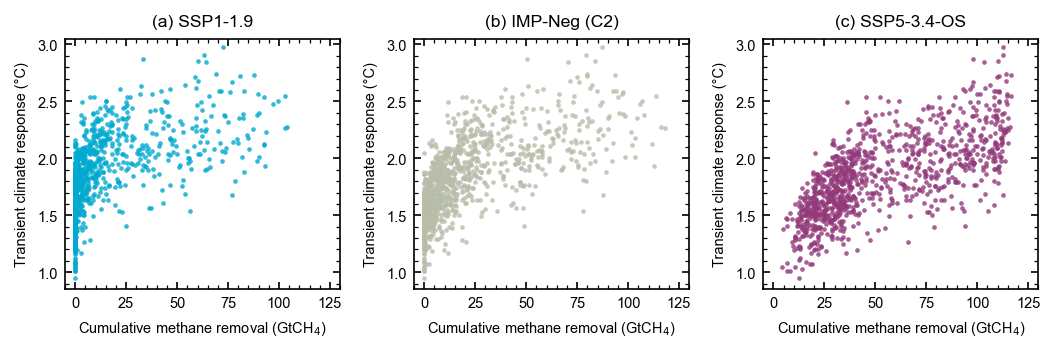

In [32]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        ecs_tcr["TCR"],
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Transient climate response (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(0.85, 3.05)
fig.tight_layout()
pl.savefig('../plots/cumCH4_TCR.png')
pl.savefig('../plots/cumCH4_TCR.pdf')

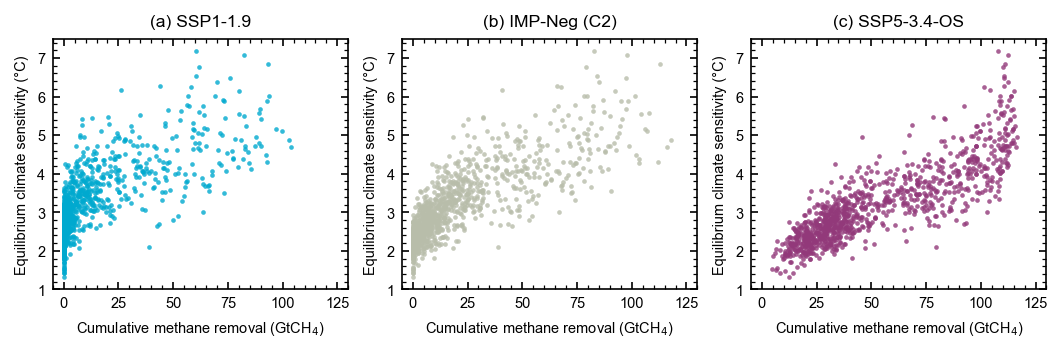

In [33]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        ecs_tcr["ECS"],
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Equilibrium climate sensitivity (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 7.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_ECS.png')
pl.savefig('../plots/cumCH4_ECS.pdf')

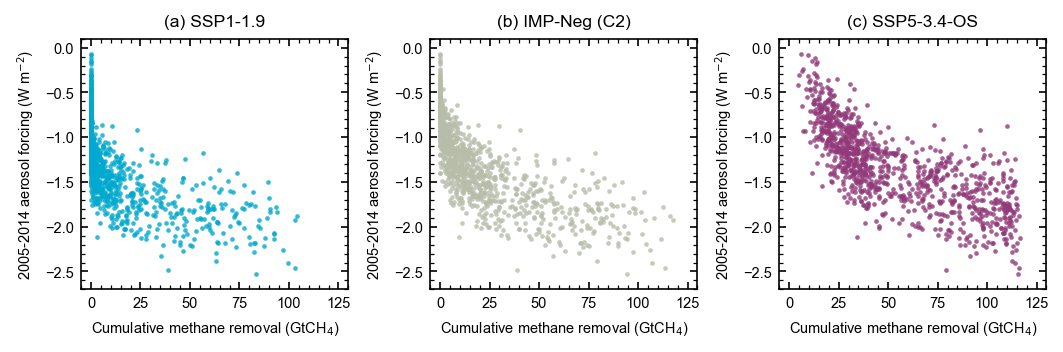

In [34]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        noch4r.forcing.loc[
            dict(scenario=scenario, specie='Aerosol-radiation interactions', timebound=np.arange(2005, 2015))
        ].mean(dim='timebound')+noch4r.forcing.loc[
            dict(scenario=scenario, specie='Aerosol-cloud interactions', timebound=np.arange(2005, 2015))
        ].mean(dim='timebound'),
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('2005-2014 aerosol forcing (W m$^{-2}$)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-2.7, 0.1)
fig.tight_layout()
pl.savefig('../plots/cumCH4_aerosolF.png')
pl.savefig('../plots/cumCH4_aerosolF.pdf')

In [35]:
zec = pd.read_csv('../results/zec_esm-bell.csv', index_col=0)
zec

,zec48_750,zec50_750,zec100_750,zec50_1000,zec100_1000
394,0.036771,0.038517,0.078881,0.067384,0.134548
1850,-0.013742,-0.013554,-0.008323,-0.008840,0.010382
1923,-0.038360,-0.039569,-0.062768,-0.042699,-0.065349
2317,0.055323,0.058367,0.133068,0.094720,0.207533
2516,-0.087737,-0.090000,-0.135349,-0.111652,-0.167017
...,...,...,...,...,...
1489640,-0.066408,-0.068851,-0.125416,-0.083119,-0.147881
1489982,-0.011015,-0.010523,0.003063,-0.004210,0.025457
1493662,0.055379,0.057355,0.091099,0.090575,0.149648
1495531,-0.050424,-0.051963,-0.080669,-0.054261,-0.078030


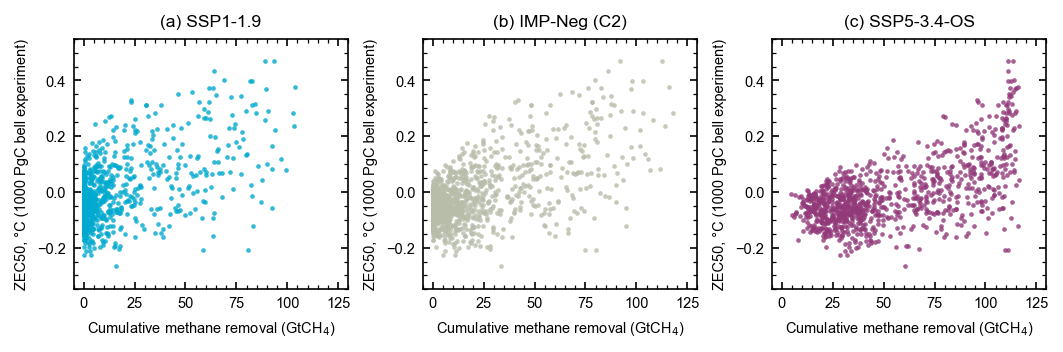

In [36]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        zec.zec50_1000,
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('ZEC50, °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.35, 0.55)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')   
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec50_1000.png')
pl.savefig('../plots/cumCH4_zec50_1000.pdf')

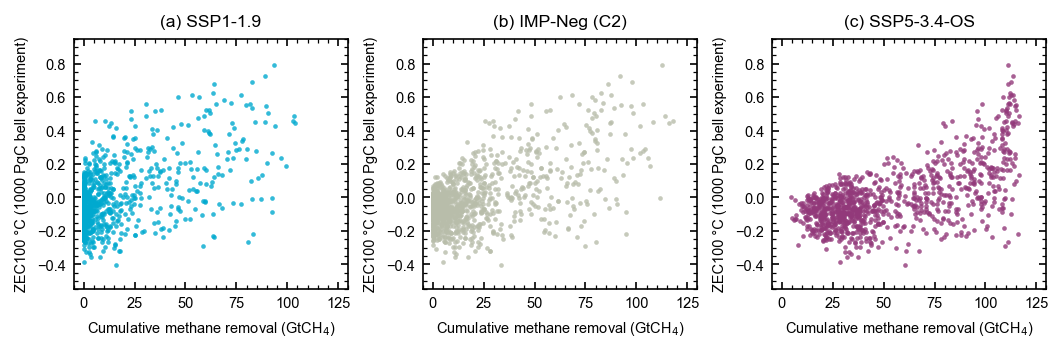

In [37]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )/1000, 
        zec.zec100_1000,
        label=labels[scenario],
        s=5,
        lw=0,
        alpha=0.8,
        color=colors[scenario]
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('ZEC100 °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.55, 0.95)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec100_1000.png')
pl.savefig('../plots/cumCH4_zec100_1000.pdf')